In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors

sns.set(style="white", context="talk")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
FILTER_STOP_WORDS = True

# Read data

In [3]:
df = pd.read_csv('data/essays.csv', encoding="ISO-8859-1")

In [4]:
df.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,1997_568848.txt,I can't believe it! It's really happening! M...,y,n,y,y,n
4,1997_688160.txt,"Well, here I go with the good old stream of co...",y,n,y,n,y


# Preprocessing

In [5]:
df.nunique()

#AUTHID    2468
TEXT       2468
cEXT          2
cNEU          2
cAGR          2
cCON          2
cOPN          2
dtype: int64

In [6]:
df = df.drop(columns='#AUTHID')
df.isna().sum()

TEXT    0
cEXT    0
cNEU    0
cAGR    0
cCON    0
cOPN    0
dtype: int64

In [7]:
CLASSES = ('cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN')

def to_binary(dataframe, fields=CLASSES):
    dataframe = dataframe.copy()
    for field in fields:
        dataframe[field] = (dataframe[field]=='y').astype(np.int16)
    return dataframe

def filter_no_emotional(df):
    df = df.copy()
    filter_field = pd.Series(np.array([True] * df.shape[0]))
    for field in CLASSES:
        filter_field &= df[field] == 0
    return filter_field

In [8]:
df = to_binary(df)

In [9]:
no_emotianal = filter_no_emotional(df)
no_emotianal.sum()

60

In [10]:
df = df[~no_emotianal].reset_index(drop=True)

In [11]:
df.head()

,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1
1,"Well, here we go with the stream of consciousn...",0,0,1,0,0
2,An open keyboard and buttons to push. The thin...,0,1,0,1,1
3,I can't believe it! It's really happening! M...,1,0,1,1,0
4,"Well, here I go with the good old stream of co...",1,0,1,0,1


In [12]:
df.shape

(2408, 6)

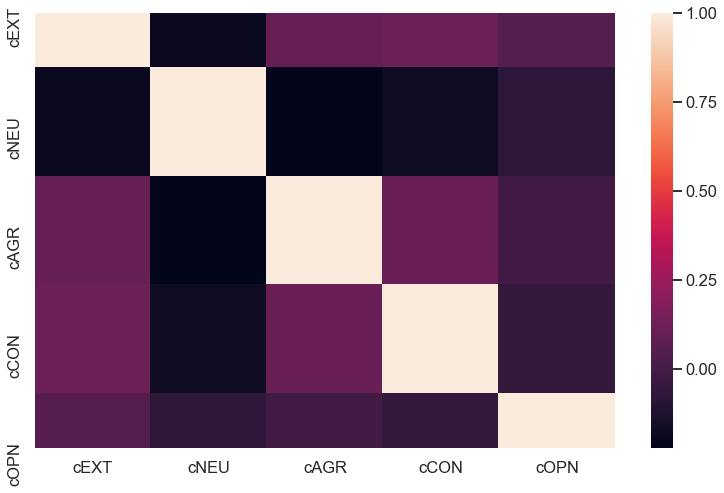

In [13]:
plt.figure(figsize=(13, 8))
sns.heatmap(df.corr());

There aren't big correlation

In [14]:
counts_classes = df[[*CLASSES]].sum()
counts_classes

cEXT    1277
cNEU    1233
cAGR    1310
cCON    1254
cOPN    1272
dtype: int64

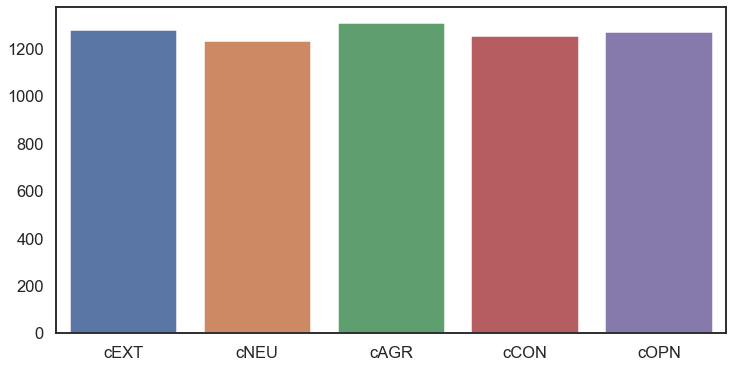

In [15]:
plt.figure(figsize=(12, 6))
sns.barplot(x=counts_classes.index, y=counts_classes.values);

Dataset is balanced.

In [16]:
X = df.TEXT.values
y = df[[*CLASSES]].values

# Text preprocessing

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
import re

def clean_str(string, TREC=False):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s ", string)
    string = re.sub(r"\'ve", " have ", string)
    string = re.sub(r"n\'t", " not ", string)
    string = re.sub(r"\'re", " are ", string)
    string = re.sub(r"\'d" , " would ", string)
    string = re.sub(r"\'ll", " will ", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " \? ", string)
#    string = re.sub(r"[a-zA-Z]{4,}", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip() if TREC else string.strip().lower()

stop_words = set(stopwords.words('english'))

def filter_stop_words(sentences):
    arr = sentences.copy()
    for i, s in enumerate(arr):
        words = nltk.word_tokenize(s)
        s = ''
        for word in words:
            if word not in stop_words:
                s += word + ' '
        arr[i] = s
    return arr

In [19]:
X = np.vectorize(clean_str)(X)
if FILTER_STOP_WORDS:
    X = filter_stop_words(X)

In [20]:
gc.collect()

6651

In [21]:
embed_size = 300 # how big is each word vector
max_features = 31000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 500 # max number of words in essay to use
EMBEDDING_FILE = 'data/glove.840B.300d.txt'

In [22]:
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789')
tokenizer.fit_on_texts(X)
list_tokenized_train = tokenizer.texts_to_sequences(X)
number_of_words_in_sentence = np.array(list(map(len, list_tokenized_train)))
X_sequence = pad_sequences(list_tokenized_train, maxlen=maxlen)
pd.DataFrame(number_of_words_in_sentence).describe()

,0
count,2408.000000
mean,298.427741
std,118.735677
min,1.000000
25%,213.000000
50%,286.000000
75%,368.000000
max,1193.000000


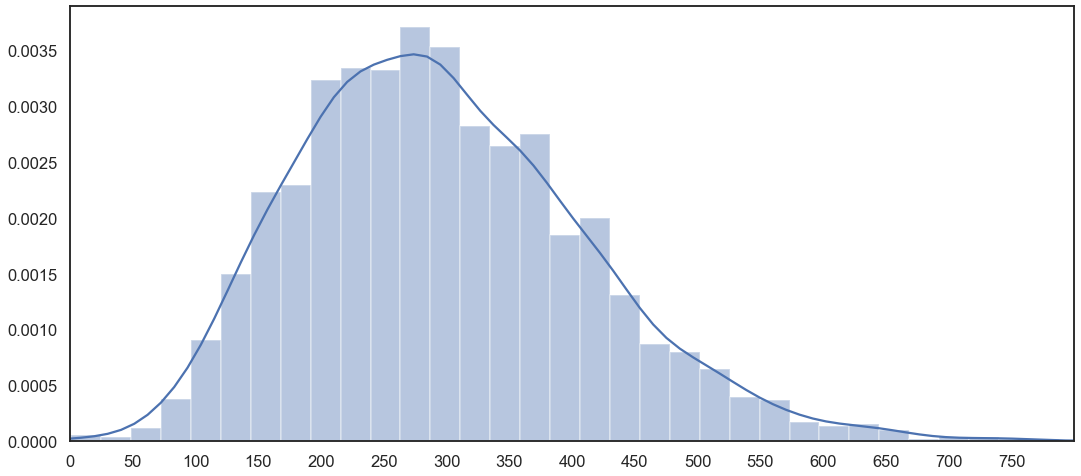

In [23]:
plt.figure(figsize=(18, 8))
ax = sns.distplot(number_of_words_in_sentence)
plt.xlim((0, 800))
ax.set_xticks(np.arange(0, 800, 50));

Distribution like normal

In [24]:
outliers_greater = number_of_words_in_sentence > maxlen
outliers_less = number_of_words_in_sentence < 150
outliers = outliers_greater | outliers_less
print(f"Outliers: {outliers.sum()}: {outliers_less.sum()} + {outliers_greater.sum()}")

Outliers: 324: 196 + 128


In [25]:
X_sequence = X_sequence[~outliers]
y = y[~outliers]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_sequence, y, test_size=0.1, random_state=17)

In [27]:
def check_unknown_index(array, unknown, likelhood=False):
    i = array.shape[0] - 1
    count = 0
    while i >= 0 and array[i] != 0:
        if array[i] in unknown:
            count += 1
        i -= 1
    if likelhood:
        return count / float(array.shape[0] - i - 1)
    return count

def count_unknowns_in_sentences(X_sequence, likelhood=False, words=None):
    if words is None:
        woords = not_known_word
    no_known_words_in_sentences = np.zeros((X_sequence.shape[0],))
    for i, sequence in enumerate(X_sequence):
        no_known_words_in_sentences[i] = check_unknown_index(sequence, words, likelhood)
    return no_known_words_in_sentences

# Read embedding

In [ ]:
model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [26]:
emb_mean, emb_std = model.vectors.mean(), model.vectors.std()
emb_mean, emb_std

(-0.003527845, 0.13315111)

In [27]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

In [28]:
not_known_word = {}

for word, i in word_index.items():
    if i >= nb_words: continue
    embedding_index = model.vocab.get(word)
    if embedding_index is not None: 
        embedding_matrix[i] = model.vectors[embedding_index.index]
    else:
        not_known_word[i] = word

len(not_known_word)

7039

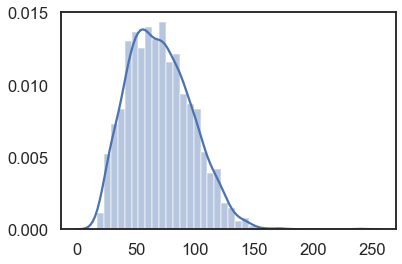

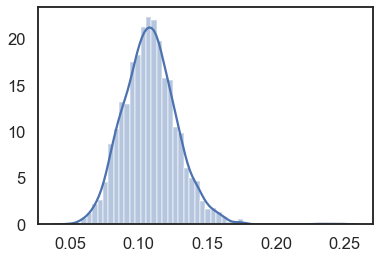

In [30]:
sns.distplot(count_unknowns_in_sentences(X_sequence))
plt.show()
sns.distplot(count_unknowns_in_sentences(X_sequence, True));

Sentences have 12% unknown words

# Try other embedding (GLOVE)

In [28]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = {}
invalid = []
for o in open(EMBEDDING_FILE, encoding='utf-8'):
    try:
        word, emb = get_coefs(*o.strip().split())
    except Exception as e:
        invalid.append(o)
    if emb is not None:
        if emb.shape[0] != embed_size:
            invalid.append(o)
        else:
            embeddings_index[word] = emb
len(invalid)

29

In [29]:
all_embs = np.stack(list(embeddings_index.values()))
emb_mean, emb_std = all_embs.mean(), all_embs.std()
emb_mean, emb_std

(-0.0058393576, 0.48782519)

In [30]:
no_known = {}

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        word = word.replace("'", "")
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            no_known[i] = word
len(no_known)

3242

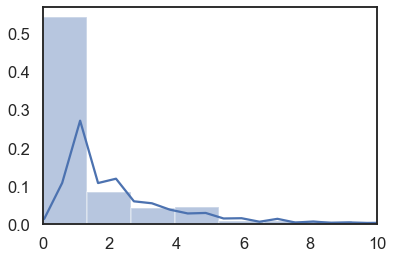

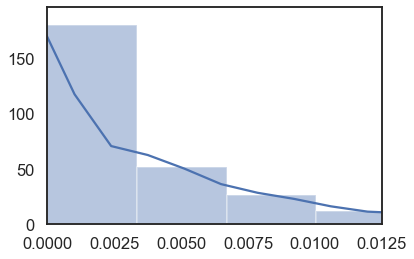

In [31]:
ax = sns.distplot(count_unknowns_in_sentences(X_sequence, words=no_known))
plt.xlim((0, 10))
plt.show();
sns.distplot(count_unknowns_in_sentences(X_sequence, True, no_known));
plt.xlim((0, 0.0125));

Model know almost all words

In [32]:
gc.collect()

11653

# Build model

In [33]:
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
%load_ext tensorboard

In [19]:
def add_axis_for_softmax(yy):
    yy = yy.reshape(-1, 1)
    temp = (yy==0).astype(np.int16)
    yy = np.append(temp, yy, axis=1)
    return yy

def merge_history(*histories):
    ext_history = {}
    for history in histories:
        if not isinstance(history, dict):
            history = history.history
        for metric in history:
            if metric in ext_history:
                ext_history[metric].extend(history[metric])
            else:
                ext_history[metric] = history[metric].copy()
    return ext_history

def draw_learning_lineplots(history, fields=None, figsize=None):
    if isinstance(history, dict):
        history = pd.DataFrame(history)
    if not figsize:
        figsize=(15, 8)
    plt.figure(figsize=figsize)
    data = history
    if fields:
        columns = []
        for field in fields:
            for col in list(history):
                if field in col:
                    columns.append(col)
        data=history[columns]
    return sns.lineplot(data=data, dashes=False)

num_model = 0

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoints = tf.keras.callbacks.ModelCheckpoint('models\model-'+str(num_model)+'-Epoch-{epoch:02d}-Loss-{val_loss:.2f}.h5',
                                                  save_best_only=True)
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stopping, checkpoints, tensorboard_callback]

optimizer = Adam(learning_rate=0.001)

In [43]:
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(LSTM(20, return_sequences=True, dropout=0.45, recurrent_dropout=0.35))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',
                                                                        #tf.keras.metrics.AUC(),
                                                                        tf.keras.metrics.Precision(),
                                                                        tf.keras.metrics.Recall()])
num_model += 1

In [44]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 300)          8731500   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 40)           51360     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 40)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 8,782,901
Trainable params: 51,401
Non-trainable params: 8,731,500
____________________________________________

In [45]:
history = model.fit(X_train, y_train[:, 0], batch_size=32, epochs=50, # validation_split=0.1, 
                    validation_data=(X_test, y_test[:, 0]), callbacks=callbacks, workers=-1, use_multiprocessing=True)

Train on 1875 samples, validate on 209 samples
Epoch 1/50
1875/1875 [==============================] - 96s 51ms/sample - loss: 0.7315 - accuracy: 0.5083 - precision_2: 0.5385 - recall_2: 0.6036 - val_loss: 0.6932 - val_accuracy: 0.5167 - val_precision_2: 0.5279 - val_recall_2: 0.9286
Epoch 2/50
1875/1875 [==============================] - 86s 46ms/sample - loss: 0.7013 - accuracy: 0.5360 - precision_2: 0.5536 - recall_2: 0.7116 - val_loss: 0.6951 - val_accuracy: 0.5407 - val_precision_2: 0.5388 - val_recall_2: 0.9911
Epoch 3/50
1875/1875 [==============================] - 89s 48ms/sample - loss: 0.6848 - accuracy: 0.5504 - precision_2: 0.5669 - recall_2: 0.6967 - val_loss: 0.6937 - val_accuracy: 0.5167 - val_precision_2: 0.5282 - val_recall_2: 0.9196
Epoch 4/50
1875/1875 [==============================] - 88s 47ms/sample - loss: 0.6801 - accuracy: 0.5568 - precision_2: 0.5679 - recall_2: 0.7374 - val_loss: 0.6927 - val_accuracy: 0.5120 - val_precision_2: 0.5281 - val_recall_2: 0.8393
E

In [40]:
%tensorboard --logdir "logs\fit"

Reusing TensorBoard on port 6006 (pid 9768), started 2 days, 22:32:27 ago. (Use '!kill 9768' to kill it.)

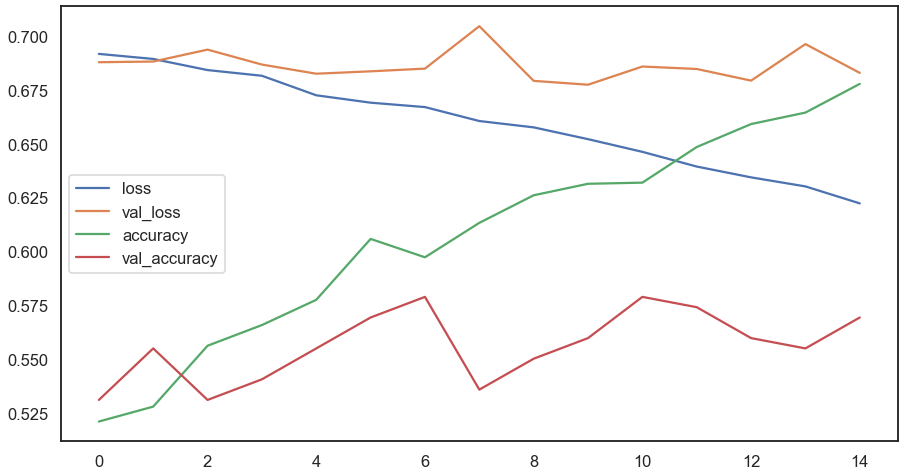

In [41]:
draw_learning_lineplots(history.history, ['loss', 'acc'])

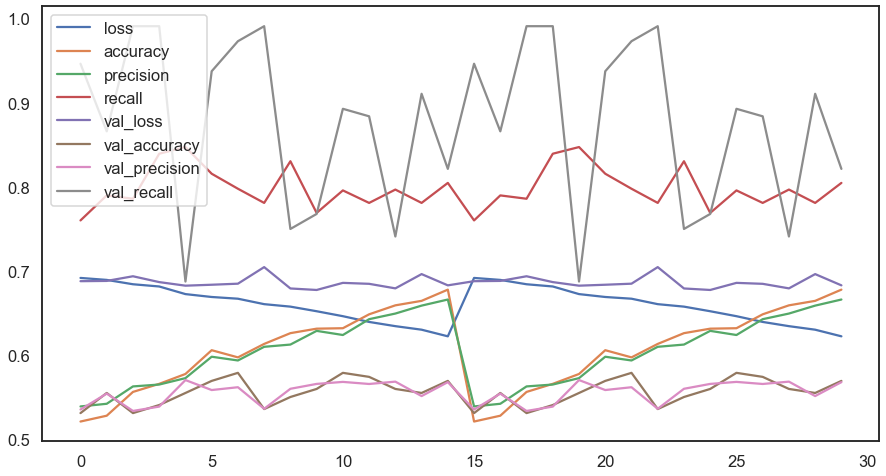

In [42]:
draw_learning_lineplots(merge_history(history, history))

In [43]:
history2 = model.fit(X_train, y_train[:, 0], batch_size=32, epochs=100, # validation_split=0.1, 
                    validation_data=(X_test, y_test[:, 0]), callbacks=callbacks, workers=-1, use_multiprocessing=True)

Train on 1875 samples, validate on 209 samples
Epoch 1/100
1875/1875 [==============================] - 82s 44ms/sample - loss: 0.6210 - accuracy: 0.6837 - precision: 0.6748 - recall: 0.7958 - val_loss: 0.6946 - val_accuracy: 0.5694 - val_precision: 0.5611 - val_recall: 0.9018
Epoch 2/100
1875/1875 [==============================] - 80s 43ms/sample - loss: 0.6141 - accuracy: 0.6853 - precision: 0.6765 - recall: 0.7958 - val_loss: 0.7219 - val_accuracy: 0.5455 - val_precision: 0.5436 - val_recall: 0.9464
Epoch 3/100
1875/1875 [==============================] - 81s 43ms/sample - loss: 0.6101 - accuracy: 0.6800 - precision: 0.6714 - recall: 0.7939 - val_loss: 0.6965 - val_accuracy: 0.5694 - val_precision: 0.5647 - val_recall: 0.8571
Epoch 4/100
1875/1875 [==============================] - 82s 44ms/sample - loss: 0.6009 - accuracy: 0.6965 - precision: 0.6893 - recall: 0.7939 - val_loss: 0.6995 - val_accuracy: 0.5789 - val_precision: 0.5682 - val_recall: 0.8929
Epoch 5/100
1875/1875 [======

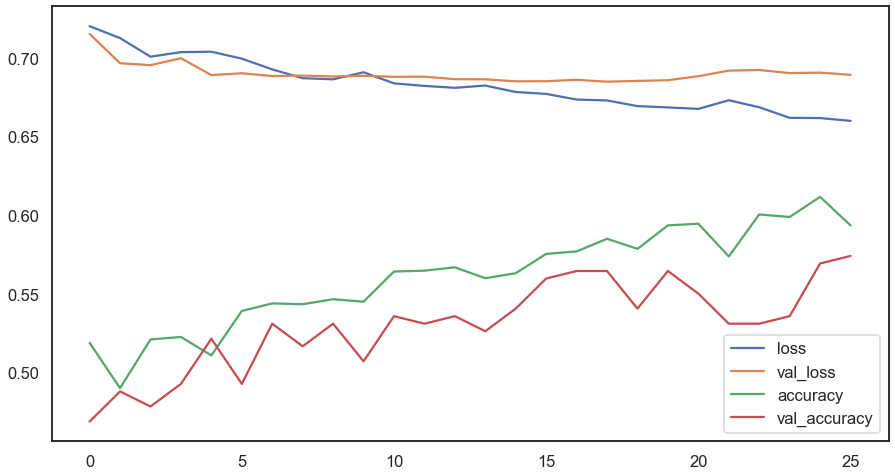

In [44]:
draw_learning_lineplots(merge_history(history, history2), ['loss', 'acc'])

In [45]:
history3 = model.fit(X_train, y_train[:, 0], batch_size=32, epochs=100, # validation_split=0.1, 
                    validation_data=(X_test, y_test[:, 0]), workers=-1, use_multiprocessing=True)

Train on 1875 samples, validate on 209 samples
Epoch 1/100
1875/1875 [==============================] - 84s 45ms/sample - loss: 0.6600 - accuracy: 0.5984 - precision: 0.5994 - recall: 0.7651 - val_loss: 0.6883 - val_accuracy: 0.5550 - val_precision: 0.5772 - val_recall: 0.6339
Epoch 2/100
1875/1875 [==============================] - 81s 43ms/sample - loss: 0.6574 - accuracy: 0.6075 - precision: 0.6137 - recall: 0.7304 - val_loss: 0.6887 - val_accuracy: 0.5694 - val_precision: 0.5833 - val_recall: 0.6875
Epoch 3/100
1875/1875 [==============================] - 81s 43ms/sample - loss: 0.6598 - accuracy: 0.6043 - precision: 0.6125 - recall: 0.7205 - val_loss: 0.6928 - val_accuracy: 0.5598 - val_precision: 0.5617 - val_recall: 0.8125
Epoch 4/100
1875/1875 [==============================] - 81s 43ms/sample - loss: 0.6535 - accuracy: 0.6112 - precision: 0.6075 - recall: 0.7839 - val_loss: 0.6866 - val_accuracy: 0.5694 - val_precision: 0.5887 - val_recall: 0.6518
Epoch 5/100
1875/1875 [======

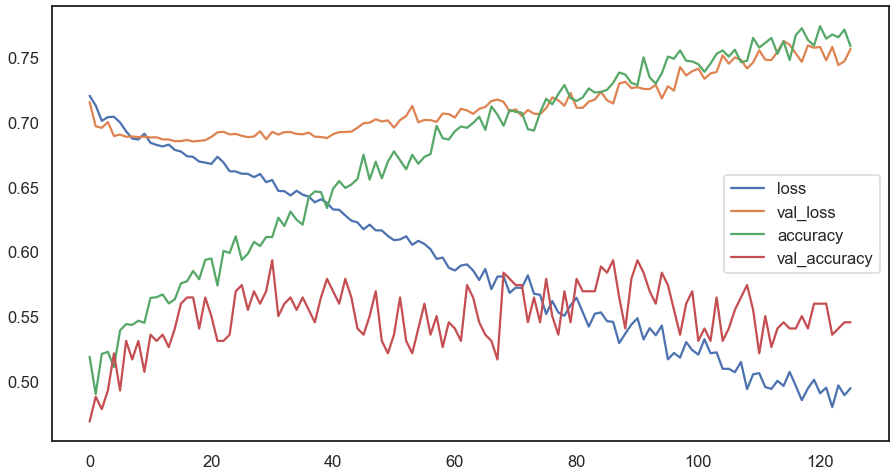

In [46]:
draw_learning_lineplots(merge_history(history, history2, history3), ['loss', 'acc'])

# Load preprocessing data and fitting models

In [6]:
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

In [7]:
MAX_LEN = 500  # max number of words in essay to use

def read_input():
    embedding_matrix = np.load('data/embedding_matrix.npy')
    X, y = np.load('data/train_input.npy'), np.load('data/train_output.npy')
    return X, y, embedding_matrix

def fit_model(model, X_train, y_train, model_name, patience=10, validation_split=0.15, epochs=50, batch_size=32):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    checkpoints = tf.keras.callbacks.ModelCheckpoint(f'models/model-{model_name}' +
                                                     '-Epoch-{epoch:02d}-Loss-{val_loss:.4f}-Acc-{val_accuracy:.4f}.h5',
                                                     save_best_only=True)
    callbacks = [early_stopping, checkpoints]
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                        callbacks=callbacks, workers=-1, use_multiprocessing=True)
    return history

In [8]:
X, y, embedding_matrix = read_input()

In [13]:
def get_model(embedding_matrix, learning_rate=0.001):
    optimizer = Adam(learning_rate=learning_rate)

    nb_words, embed_size = embedding_matrix.shape
    inp = Input(shape=(MAX_LEN,))
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(LSTM(10, return_sequences=True, dropout=0.5, recurrent_dropout=0.4))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',
                                                                            #tf.keras.metrics.AUC(),
                                                                            tf.keras.metrics.Precision(),
                                                                            tf.keras.metrics.Recall()])
    return model

In [14]:
histories = []
for i in range(y.shape[1]):
    model = get_model(embedding_matrix)
    histories.append(fit_model(model, X, y[:, i], i))
    print(f"Model for {i} class has been fitted.")

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 500, 300)          8731500   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 500, 20)           24880     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 20)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 21        
Total params: 8,756,401
Trainable params: 24,901
Non-trainable params: 8,731,500
_________________________________________________________________
None
Train on 1771 samples, validate on 313 samples
Epoch 1/50
1771/1771 [==============================] - 82

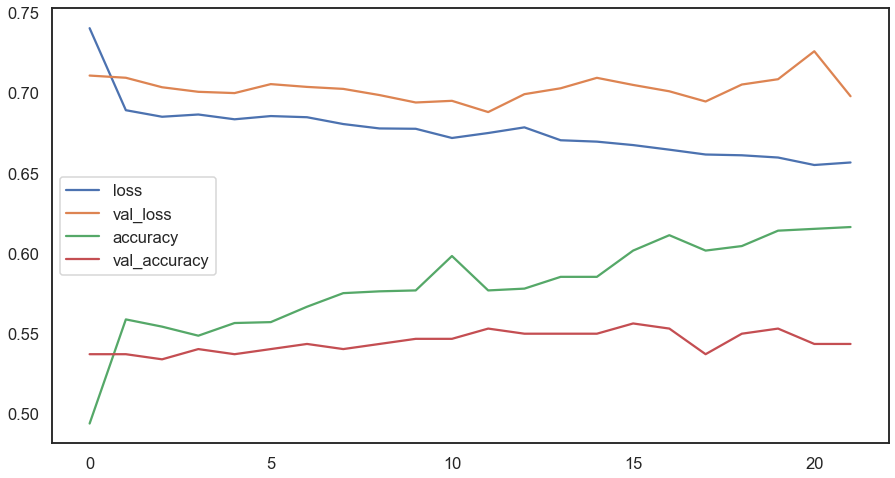

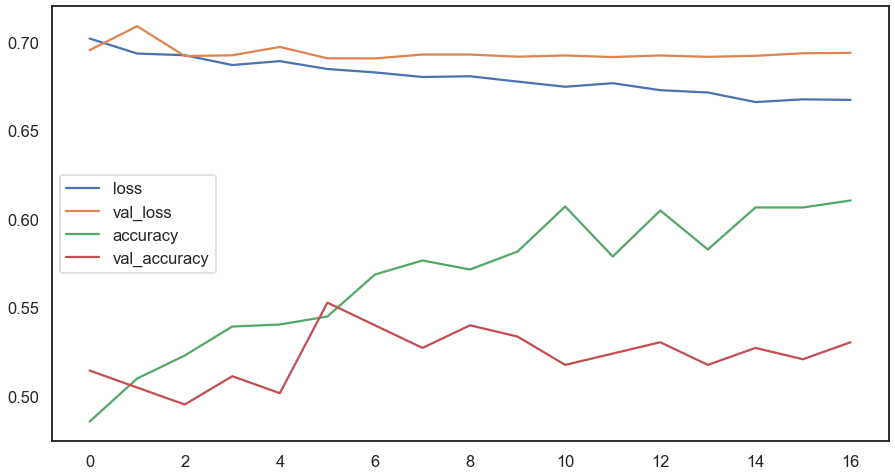

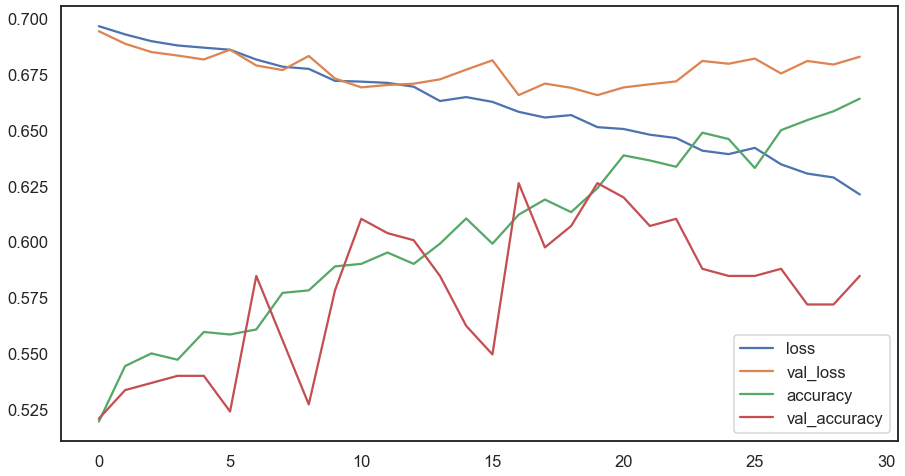

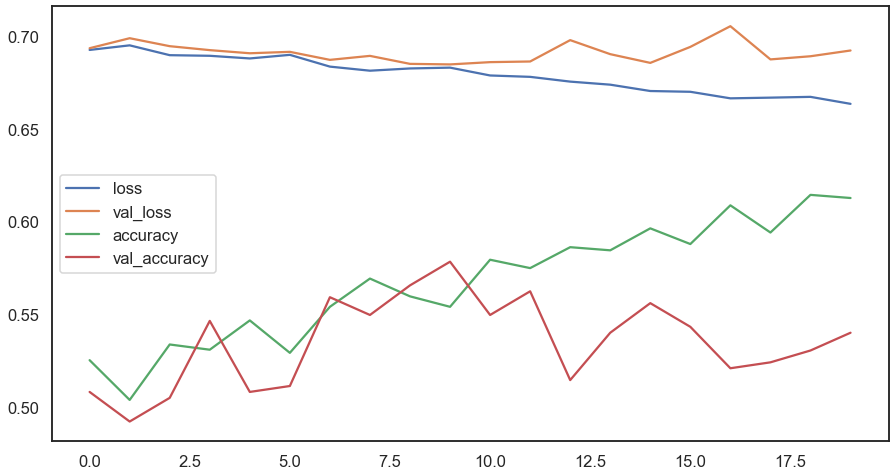

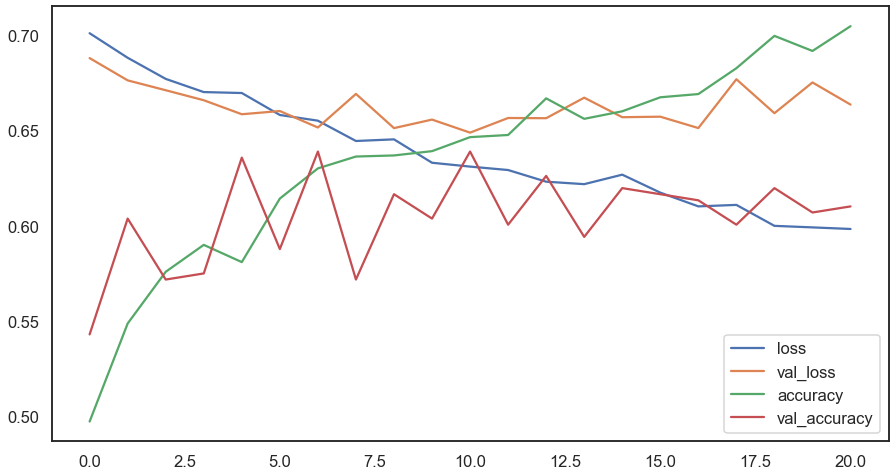

In [26]:
for history in histories:
    draw_learning_lineplots(history.history, ['loss', 'acc'])

# Load best models and make predicts

In [13]:
import os
import tensorflow as tf
import numpy as np

class MyModel():
    def __init__(self, path='models/', metric='loss'):
        self.__path = path
        models = self.__read_models(path)
        models_files = self.__parse_models_name(models)
        models = self.__choose_best(models_files, metric)
        self.__models = self.__load_models(models)
    
    
    def predict_prob(self, X):
        probs = []
        for model in self.__models:
            predicts = model.predict(X)
            probs.append(predicts)
        probs = np.hstack(probs)
        return probs
    
    def predict(self, X, epsilon=0.5):
        probs = self.predict_prob(X)
        predicts = (probs >= epsilon).astype(np.int)
        return predicts
    
    def __read_models(self, path):
        return os.listdir(path)
    
    def __parse_models_name(self, models):
        models_dirs = [[] for _ in range(5)]
        for model in models:
            temp = model.split('-')
            m = {'file': model, 'loss': float(temp[5]), 'acc': float(temp[-1][:-3])}
            num_model = int(temp[1])
            models_dirs[num_model].append(m)
        return models_dirs
    
    def __choose_best(self, models_dirs, metric):
        models = []
        for model in models_dirs:
            if metric == 'loss':
                model.sort(key=lambda x: x['loss'])
            else:
                model.sort(key=lambda x: x['acc'], reverse=True)
            models.append(model[0])
        return models
    
    def __load_models(self, models):
        loaded = []
        for model in models:
            model = tf.keras.models.load_model(self.__path + model['file'])
            loaded.append(model)
        return loaded

In [14]:
my_model = MyModel()

In [17]:
predicts = my_model.predict(X[:5])

In [18]:
predicts

array([[1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 1, 0, 0, 1],
       [1, 1, 1, 1, 0],
       [1, 0, 1, 0, 1]])

In [19]:
y[:5]

array([[0, 1, 1, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 1, 1],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 0, 1]], dtype=int16)